## Data Acquisition and Sweeper module for Lock-In devices

In [1]:
# import the ZI QCoDeS drivers

from zhinst.qcodes import MFLI
import matplotlib.pyplot as plt

In [2]:
# connect to MFLI device with specified serial, interface and host

mf = MFLI("mf", "dev3337", interface="pcie", host="10.42.3.78")

Successfully connected to data server at 10.42.3.788004 api version: 6
Successfully connected to device DEV3337 on interface PCIE
Connected to: Zurich Instruments MFLI (serial:dev3337, firmware:65939) in 0.68s


### Overview

The MFLI QCoDeS instrument has several submodules and parameters that correspond to the hirarchy of the instrument's nodetree. The submodules correspond to the nodes in the nodetree. They are `InstrumentChannels` and can each again have submodules or QCoDeS `Parameters`. 

In [3]:
for m in mf.submodules:
    print(m)

daq
sweeper
stats
oscs
demods
extrefs
triggers
status
dios
auxins
system
sigins
currins
sigouts
features
auxouts
tu
imps


In [4]:
for p in mf.demods[0].parameters:
    print(p)

adcselect
order
rate
oscselect
harmonic
phaseshift
sinc
bypass
timeconstant
enable
freq
trigger
phaseadjust
sample


All the available settings of the instruments are automatically translated to QCoDeS parameters when connecting the device. The information about the parameter is transferred to the QCoDeS parameter.

In [5]:
doc = mf.oscs[0].freq.__doc__
print(doc)

* `Node`: /DEV3337/OSCS/0/FREQ
* `Description`: Frequency control for each oscillator.
* `Properties`: Read, Write, Setting
* `Type`: Double
* `Unit`: Hz


Parameter class:

* `name` freq
* `label` freq
* `unit` Hz
* `vals` None


In [6]:
mf.oscs[0].freq()

99999.99999990905

In [7]:
mf.oscs[0].freq(20e3)

In [8]:
mf.oscs[0].freq()

20000.000000024444

## Data Acquisition Module

In [9]:
# available parameters

for p in mf.daq.parameters:
    print(p)

awgcontrol
bandwidth
bitmask
bits
buffercount
buffersize
clearhistory
count
delay
device
duration
edge
enable
endless
eventcount_mode
fft_absolute
fft_window
findlevel
flags
forcetrigger
grid_cols
grid_direction
grid_mode
grid_overwrite
grid_repetitions
grid_rowrepetition
grid_rows
grid_waterfall
historylength
holdoff_count
holdoff_time
hysteresis
level
preview
pulse_max
pulse_min
refreshrate
save_csvlocale
save_csvseparator
save_directory
save_fileformat
save_filename
save_save
save_saveonread
spectrum_autobandwidth
spectrum_enable
spectrum_frequencyspan
spectrum_overlapped
triggered
triggernode
type


In [10]:
# settings for an example measurement

mf.sigouts.on(1)
mf.daq.spectrum_enable(1)
mf.daq.fft_window("rectangular")
mf.daq.type("continuous")
mf.daq.grid_cols(512)
mf.daq.grid_rows(10)

In [11]:
# list available signals sources

mf.daq.signals_list()

['demod1', 'demod2', 'imp']

In [12]:
# and according singal types

mf.daq.signals_list("demod1")

['x', 'y', 'r', 'xiy', 'theta', 'frequency', 'auxin1', 'auxin2', 'dio']

In [13]:
# add signals to the measurement

mf.daq.signals_clear()
signal1 = mf.daq.signals_add("demod1", "r")     # specify signal_source and signal_type
signal2 = mf.daq.signals_add("demod1", "theta")
signal3 = mf.daq.signals_add("demod1", "xiy", fft=True)

In [14]:
# list all the signal nodes added 

mf.daq.signals

['/dev3337/demods/0/sample.r.avg',
 '/dev3337/demods/0/sample.theta.avg',
 '/dev3337/demods/0/sample.xiy.fft.abs.avg']

In [15]:
# start the measurement

mf.daq.measure()

subscribed to: /dev3337/demods/0/sample.r.avg
subscribed to: /dev3337/demods/0/sample.theta.avg
subscribed to: /dev3337/demods/0/sample.xiy.fft.abs.avg
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 20.0%
Progress: 30.0%
Finished
getting result from: /dev3337/demods/0/sample.r.avg
getting result from: /dev3337/demods/0/sample.theta.avg
getting result from: /dev3337/demods/0/sample.xiy.fft.abs.avg


In [16]:
# retrieve the measurement results

result1 = mf.daq.results[signal1]
result2 = mf.daq.results[signal2]
result3 = mf.daq.results[signal3]

In [17]:
result3


path:        /dev3337/demods/0/sample.xiy.fft.abs.avg
value:       (10, 511)
frequency:   (511,)

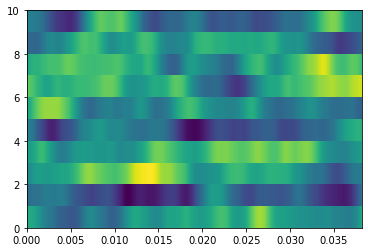

In [18]:
# plot the measured grid

plt.imshow(result1.value, extent=[result1.time[0], result1.time[-1], 0, 10], aspect="auto")
plt.show()

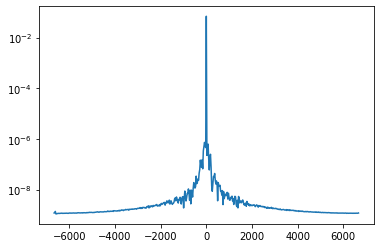

In [19]:
# plot the FFT

plt.plot(result3.frequency, result3.value[0])
plt.yscale("log")
plt.show()

## Sweeper Module

In [20]:
for p in mf.sweeper.parameters:
    print(p)

averaging_sample
averaging_tc
averaging_time
awgcontrol
bandwidth
bandwidthcontrol
bandwidthoverlap
clearhistory
device
endless
gridnode
historylength
loopcount
maxbandwidth
omegasuppression
order
phaseunwrap
remainingtime
samplecount
save_csvlocale
save_csvseparator
save_directory
save_fileformat
save_filename
save_save
save_saveonread
scan
settling_inaccuracy
settling_tc
settling_time
sincfilter
start
stop
xmapping


In [21]:
# what parameters are available to sweep?

mf.sweeper.sweep_parameter_list()

['auxout1offset',
 'auxout2offset',
 'auxout3offset',
 'auxout4offset',
 'demdod1phase',
 'demdod2phase',
 'frequency',
 'output1amp',
 'output1offset']

In [22]:
# prepare a frequency sweep

mf.sweeper.start(1e3)
mf.sweeper.stop(510e3)
mf.sweeper.samplecount(100)
mf.sweeper.sweep_parameter("frequency")

# add a singal source

signal1 = mf.sweeper.signals_add("demod1")

set sweep parameter to 'frequency': 'oscs/0/freq'


In [23]:
mf.sweeper.signals

['/dev3337/demods/0/sample']

In [24]:
# perform measurement

mf.sweeper.measure(timeout=100)

# get result
result1 = mf.sweeper.results[signal1]

subscribed to: /dev3337/demods/0/sample
Sweeping 'oscs/0/freq' from 1000.0 to 510000.0
Progress: 0.0%
Progress: 8.0%
Progress: 17.0%
Progress: 28.0%
Progress: 40.0%
Progress: 52.0%
Progress: 62.0%
Progress: 71.0%
Progress: 77.0%
Progress: 82.0%
Progress: 90.0%
Progress: 90.0%
Progress: 91.0%
Progress: 91.0%
Progress: 91.0%
Progress: 91.0%
Progress: 92.0%
Progress: 92.0%
Progress: 92.0%
Progress: 92.0%
Progress: 92.0%
Progress: 92.0%
Progress: 92.0%
Progress: 92.0%
Progress: 92.0%
Progress: 92.0%
Progress: 93.0%
Progress: 93.0%
Progress: 93.0%
Progress: 93.0%
Progress: 93.0%
Progress: 93.0%
Progress: 93.0%
Progress: 93.0%
Progress: 93.0%
Progress: 93.0%
Progress: 93.0%
Progress: 94.0%
Progress: 94.0%
Progress: 94.0%
Progress: 94.0%
Progress: 94.0%
Progress: 94.0%
Progress: 94.0%
Progress: 94.0%
Progress: 95.0%
Progress: 95.0%
Progress: 95.0%
Progress: 95.0%
Progress: 95.0%
Progress: 95.0%
Progress: 95.0%
Progress: 95.0%
Progress: 95.0%
Progress: 95.0%
Progress: 95.0%
Progress: 95.0%
Pro

In [27]:
result1


attributes:
 - header
 - timestamp
 - samplecount
 - flags
 - sampleformat
 - sweepmode
 - bandwidthmode
 - auxin0
 - auxin0pwr
 - auxin0stddev
 - auxin1
 - auxin1pwr
 - auxin1stddev
 - bandwidth
 - frequency
 - frequencypwr
 - frequencystddev
 - grid
 - phase
 - phasepwr
 - phasestddev
 - r
 - rpwr
 - rstddev
 - settling
 - tc
 - tcmeas
 - x
 - xpwr
 - xstddev
 - y
 - ypwr
 - ystddev
 - count
 - nexttimestamp
 - settimestamp

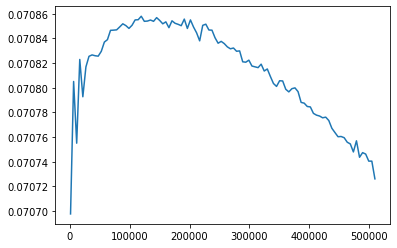

In [28]:
plt.plot(result1.grid, result1.x)
plt.show()

In [30]:
mf.sweeper.application_list()

['parameter_sweep',
 'parameter_sweep_avg',
 'noise_amplitude_sweep',
 'frequency_response_analyzer',
 '3-omega_sweep',
 'fra_sinc_filter',
 'impedance']

In [31]:
mf.sweeper.application("parameter_sweep_avg")

setting 'averaging/sample' to 20
setting 'averaging/tc' to 15
setting 'averaging/time' to 0.02
